
### 05 — AutoEncoder for Collaborative Filtering
Train a denoising autoencoder on the user–movie rating matrix to learn dense representations and produce recommendations.


In [1]:
from pathlib import Path
import sys

import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))

from autoencoder_model import (
    encode_dense_splits,
    AutoEncoderDataset,
    build_autoencoder,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'
MODELS = BASE / 'models'
MODELS.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [2]:
train_df = pd.read_csv(PROC / "ratings_train.csv")
valid_df = pd.read_csv(PROC / "ratings_valid.csv")
test_df  = pd.read_csv(PROC / "ratings_test.csv")

for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"{name} -> shape={df.shape}  users={df.userId.nunique()}  items={df.movieId.nunique()}")


train -> shape=(31316, 7)  users=479  items=426
valid -> shape=(3669, 7)  users=479  items=426
test -> shape=(3669, 7)  users=479  items=426


In [3]:
# convert dataframe to dense matrix for autoencoder
train_mat, train_mask, valid_mat, valid_mask, test_mat, test_mask, user2idx, item2idx = encode_dense_splits(train_df, valid_df, test_df)
print('Matrix shape:', train_mat.shape, 'train density:', round(float(train_mask.mean()), 4))


Matrix shape: (479, 426) train density: 0.1535


In [4]:
# Build Dataloader
BATCH_SIZE = 64
train_loader = DataLoader(AutoEncoderDataset(train_mat, train_mask), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(AutoEncoderDataset(valid_mat, valid_mask), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(AutoEncoderDataset(test_mat, test_mask), batch_size=BATCH_SIZE, shuffle=False)


In [5]:
# Build Autoencoder model and optimizer
model = build_autoencoder(n_items=train_mat.shape[1], hidden_dims=(512, 256, 128), dropout=0.25, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)


In [6]:
EPOCHS = 80
PATIENCE = 8
best_val_rmse = float('inf')
best_epoch = 0
wait = 0

history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
checkpoint_path = MODELS / 'autoencoder_best.pth'

for epoch in range(1, EPOCHS + 1):
    train_metrics = run_epoch(model, train_loader, optimizer=optimizer, device=device)
    val_metrics = run_epoch(model, valid_loader, optimizer=None, device=device)

    history['train_loss'].append(train_metrics.loss)
    history['val_loss'].append(val_metrics.loss)
    history['val_rmse'].append(val_metrics.rmse)
    history['val_mae'].append(val_metrics.mae)

    print(
        f"Epoch {epoch:02d} | train_loss={train_metrics.loss:.4f} | "
        f"val_loss={val_metrics.loss:.4f} | val_RMSE={val_metrics.rmse:.4f} | val_MAE={val_metrics.mae:.4f}"
    )

    if val_metrics.rmse + 1e-4 < best_val_rmse:
        best_val_rmse = val_metrics.rmse
        best_epoch = epoch
        wait = 0
        torch.save(
            {
                'state_dict': model.state_dict(),
                'user2idx': user2idx.to_dict(),
                'item2idx': item2idx.to_dict(),
                'history': history,
                'best_val_rmse': best_val_rmse,
            },
            checkpoint_path,
        )
    else:
        wait += 1
        if wait >= PATIENCE:
            print('Early stopping triggered.')
            break

print(f"Best validation RMSE {best_val_rmse:.4f} at epoch {best_epoch}")


Epoch 01 | train_loss=6.9031 | val_loss=3.9277 | val_RMSE=1.9843 | val_MAE=1.6107
Epoch 02 | train_loss=3.2468 | val_loss=3.2266 | val_RMSE=1.7987 | val_MAE=1.4490
Epoch 03 | train_loss=2.9355 | val_loss=3.2406 | val_RMSE=1.7821 | val_MAE=1.4353
Epoch 04 | train_loss=2.8526 | val_loss=3.2593 | val_RMSE=1.7792 | val_MAE=1.4334
Epoch 05 | train_loss=2.7987 | val_loss=3.2282 | val_RMSE=1.7691 | val_MAE=1.4243
Epoch 06 | train_loss=2.8006 | val_loss=3.1705 | val_RMSE=1.7551 | val_MAE=1.4139
Epoch 07 | train_loss=2.7796 | val_loss=3.1795 | val_RMSE=1.7569 | val_MAE=1.4159
Epoch 08 | train_loss=2.7688 | val_loss=3.1547 | val_RMSE=1.7479 | val_MAE=1.4094
Epoch 09 | train_loss=2.7153 | val_loss=3.1267 | val_RMSE=1.7371 | val_MAE=1.4004
Epoch 10 | train_loss=2.6980 | val_loss=3.0680 | val_RMSE=1.7190 | val_MAE=1.3872
Epoch 11 | train_loss=2.6673 | val_loss=3.0708 | val_RMSE=1.7179 | val_MAE=1.3855
Epoch 12 | train_loss=2.7100 | val_loss=3.0742 | val_RMSE=1.7188 | val_MAE=1.3866
Epoch 13 | train

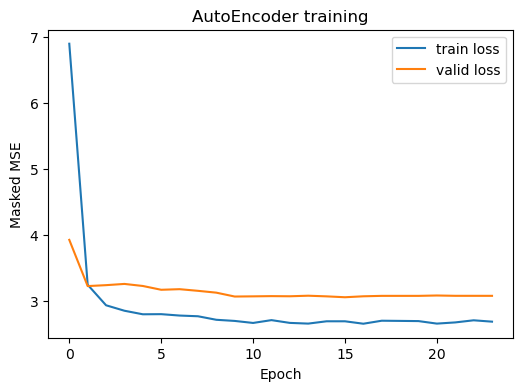

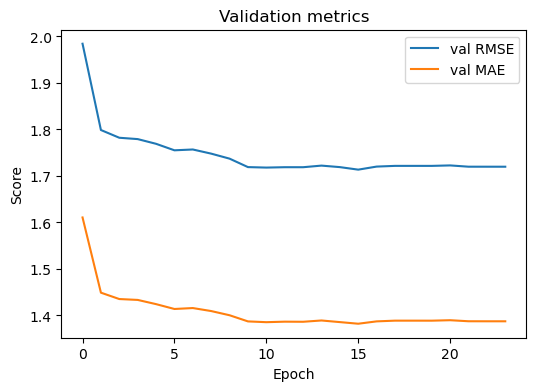

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Masked MSE')
plt.legend()
plt.title('AutoEncoder training')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['val_rmse'], label='val RMSE')
plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation metrics')
plt.show()


In [8]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

test_metrics = run_epoch(model, test_loader, optimizer=None, device=device)
print(f"Test RMSE: {test_metrics.rmse:.4f} | Test MAE: {test_metrics.mae:.4f}")


Test RMSE: 1.7127 | Test MAE: 1.3614


In [10]:
train_seen = build_seen_items(train_df)
movies_meta = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df['userId'].sample(1, random_state=42).iloc[0])
recs = recommend_topk(
    model,
    sample_user,
    train_matrix=train_mat,
    user2idx=user2idx,
    item2idx=item2idx,
    train_seen=train_seen,
    k=10,
    device=device,
).merge(movies_meta, on='movieId', how='left').loc[:, ["movieId", "title", "genres", "pred_rating", "raw_score"]]

print('Sample user:', sample_user)
display(recs)


Sample user: 591


,movieId,title,genres,pred_rating,raw_score
0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5.0,135.684006
1,4226,Memento (2000),Mystery|Thriller,5.0,130.229004
2,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,5.0,129.408997
3,1213,Goodfellas (1990),Crime|Drama,5.0,124.892998
4,4011,Snatch (2000),Comedy|Crime|Thriller,5.0,124.746002
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,124.207001
6,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,5.0,123.680000
7,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,5.0,122.667999
8,368,Maverick (1994),Adventure|Comedy|Western,5.0,121.344002
9,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,5.0,121.152000
